In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers

(2115, 22, 1000)


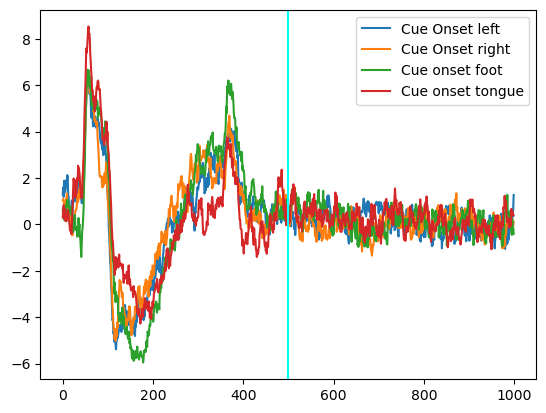

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

_=plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [4]:
def time_warp(data, shift_max=2):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift, axis=2)  # roll along the time axis

def shuffle_channels(data):
    np.random.shuffle(data.transpose(1,0,2))  # shuffle along the channel axis
    return data

def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        print('Shape of X after subsampling:',X_subsample.shape)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

       # Time warp and channel shuffle as data augmentation
    for i in range(2):  # Increase this number to generate more augmented data
        X_time_warp = time_warp(X[:, :, i::sub_sample], shift_max=2)
        X_channel_shuffle = shuffle_channels(X[:, :, i::sub_sample])
        
        total_X = np.vstack((total_X, X_time_warp, X_channel_shuffle))
        total_y = np.hstack((total_y, y, y))  # Duplicate the labels for the augmented data

    print('Shape of X after time warp, channel shuffle and concatenating:', total_X.shape)
    print('Shape of Y:', total_y.shape)
        


    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming test:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling test:',total_X.shape)
    
    return total_X





In [5]:

## Random splitting

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = X_train_valid[ind_train], X_train_valid[ind_valid] 
y_train, y_valid = y_train_valid[ind_train], y_train_valid[ind_valid]

## Preprocessing the dataset

x_train, y_train = train_data_prep(X_train, y_train, 2, 2, True)
x_valid, y_valid = train_data_prep(X_valid, y_valid, 2, 2, True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
X_test_prep = test_data_prep(X_test)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1615, 22, 800)
Shape of X after maxpooling: (1615, 22, 400)
Shape of X after averaging+noise and concatenating: (3230, 22, 400)
Shape of X after subsampling: (1615, 22, 400)
Shape of X after subsampling: (1615, 22, 400)
Shape of X after subsampling and concatenating: (6460, 22, 400)
Shape of Y: (6460,)
Shape of X after time warp, channel shuffle and concatenating: (12920, 22, 400)
Shape of Y: (12920,)
Shape of X after trimming: (500, 22, 800)
Shape of X after maxpooling: (500, 22, 400)
Shape of X after averaging+noise and concatenating: (1000, 22, 400)
Shape of X after subsampling: (500, 22, 400)
Shape of X after subsampling: (500, 22, 400)
Shape of X after subsampling and concatenating: (2000, 22, 400)
Shape of Y: (2000,)
Shape of X after time warp, channel shuffle and concatenating: (4000, 22, 400)
Shape of Y: (4000,)
Shape of training set: (12920, 22, 400)
Shape of validation set: (4000, 22, 400)
Shape of training labels: (12920,)
Shape of validation labe

In [6]:
from tensorflow.keras.layers import GRU

# Building the CNN model using sequential class
cnn_GRU_model = Sequential()

# Conv. block 1
cnn_GRU_model.add(Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu', input_shape=(400,1,22)))
cnn_GRU_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
cnn_GRU_model.add(BatchNormalization())
cnn_GRU_model.add(Dropout(0.6))

# Conv. block 2
cnn_GRU_model.add(Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu'))
cnn_GRU_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_GRU_model.add(BatchNormalization())
cnn_GRU_model.add(Dropout(0.6))

# Conv. block 3
cnn_GRU_model.add(Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu'))
cnn_GRU_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_GRU_model.add(BatchNormalization())
cnn_GRU_model.add(Dropout(0.6))

# Conv. block 4
cnn_GRU_model.add(Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu'))
cnn_GRU_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_GRU_model.add(BatchNormalization())
cnn_GRU_model.add(Dropout(0.6))

# FC+RNN layers
cnn_GRU_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
cnn_GRU_model.add(Dense((40))) # FC layer with 100 units
cnn_GRU_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
cnn_GRU_model.add(GRU(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False)) # GRU layer with dropout

# Output layer with Softmax activation 
cnn_GRU_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
cnn_GRU_model.summary()

/Users/haoyuluo/anaconda3/envs/new183/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/Users/haoyuluo/anaconda3/envs/new183/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 400, 1, 25)     │         2,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 134, 1, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 134, 1, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 134, 1, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 134, 1, 50)     │         6,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 1, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 1, 50)      │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 1, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 1, 100)     │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 100)     │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 1, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 1, 200)     │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 1, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 1, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 1, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        40,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 10)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,349 (688.86 KB)

 Trainable params: 175,599 (685.93 KB)

 Non-trainable params: 750 (2.93 KB)

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Compiling the model
cnn_GRU_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_GRU_model_results = cnn_GRU_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




Epoch 1/100
202/202 [==============================] - 58s 255ms/step - loss: 1.3896 - accuracy: 0.2593 - val_loss: 1.3788 - val_accuracy: 0.2803
Epoch 2/100
202/202 [==============================] - 50s 250ms/step - loss: 1.3661 - accuracy: 0.3050 - val_loss: 1.3490 - val_accuracy: 0.3305
Epoch 3/100
202/202 [==============================] - 50s 249ms/step - loss: 1.3425 - accuracy: 0.3359 - val_loss: 1.3211 - val_accuracy: 0.3153
Epoch 4/100
202/202 [==============================] - 50s 247ms/step - loss: 1.3164 - accuracy: 0.3746 - val_loss: 1.2979 - val_accuracy: 0.3543
Epoch 5/100
202/202 [==============================] - 50s 249ms/step - loss: 1.2883 - accuracy: 0.3945 - val_loss: 1.2787 - val_accuracy: 0.3602
Epoch 6/100
202/202 [==============================] - 50s 248ms/step - loss: 1.2678 - accuracy: 0.4189 - val_loss: 1.2767 - val_accuracy: 0.4055
Epoch 7/100
202/202 [==============================] - 51s 251ms/step - loss: 1.2508 - accuracy: 0.4256 - val_loss: 1.2907 -

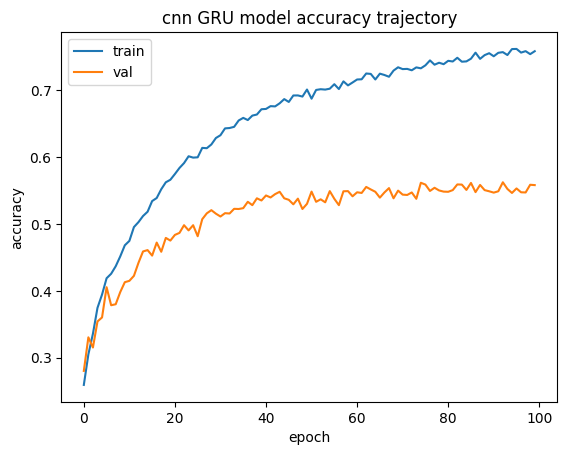

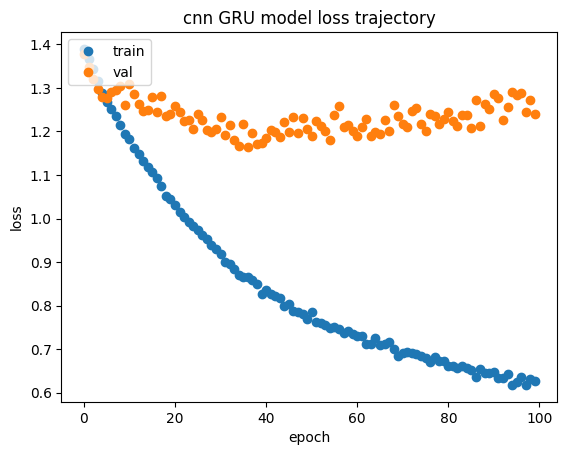

Test accuracy of the cnn_GRU_model model: 0.5801354646682739


In [8]:
# Plotting accuracy trajectory
plt.plot(cnn_GRU_model_results.history['accuracy'])
plt.plot(cnn_GRU_model_results.history['val_accuracy'])
plt.title('cnn GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_GRU_model_results.history['loss'],'o')
plt.plot(cnn_GRU_model_results.history['val_loss'],'o')
plt.title('cnn GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the hybrid CNN-LSTM model

cnn_GRU_model_score = cnn_GRU_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the cnn_GRU_model model:',cnn_GRU_model_score[1])